<a href="https://colab.research.google.com/github/Imartinezcuevas/RL_MC_OL/blob/main/SARSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SARSA
*Description:* Este notebook describe un experimento de aprendizaje por refuerzo utilizando el algoritmo de SARSA.
El propósito de este análisis es explicar la implementación del agente y probar con dos entornos (FrozenLake y Taxi) que funciona correctamente.

    Author: Iván Martínez Cuevas y Antonio Orenes Lucas
    Email: ivan.martinezc@um.es y antonio.orenesl@um.es
    Date: 2025/02/12

This software is licensed under the GNU General Public License v3.0 (GPL-3.0),
with the additional restriction that it may not be used for commercial purposes.

For more details about GPL-3.0: https://www.gnu.org/licenses/gpl-3.0.html

# Introducción a Monte Carlo On-Policy

SARSA es un algoritmo de aprendizaje por refuerzo on-policy que aprende una política de control directamente de la experiencia. SARSA actualiza los valores Q utilizando la acción que realmente se toma en el siguiente estado, lo que lo hace más adecuado para entornos estocásticos y situaciones donde la seguridad es importante.

## Componentes Clave
1. Agente (`Agent`, `TabularAgent`, `SARSAAgent`):
  * La clase `Agent` define la estructura general de un agente de RL.
  * `TabularAgent` espcecializa el agente para entornos con espacios de estados y acciones discretos, utilizando una tabla Q para almacenar los valores de acción.
  * `SARSAAgent` implementa el algoritmo SARSA, actualizando los valores Q según la experiencia (estado, acción, recompensa, siguiente estado, siguiente acción).

2. Política (`Policy`, `EpsilonGreedyPolicy`):
  * La clase `Policy` define la estructura general de una política.
  * `EpsilonGreedyPolicy` basada en la política usada en el ejemplo.
    * Política epsilon-soft: Se define una política donde todas las acciones tienen una probabilidad de ser elegida.
    * Política epsilon-greedy: basada en la política epsilon-soft. De esta forma el agente tiene una pequeña probabilidad de explorar (tomar una acción aleatoria) y una mayor probabilidad de explotar (tomar la acción que considera mejor). Esto permite equilibrar la exploración y la explotación.

3. Entorno (`gym.Env`):
  * El entorno de Gymnasium donde el agente interactua.
  * Los entornos probados son:
    * FrozenLake:  entorno de cuadrícula simple donde el agente debe navegar desde un punto de inicio hasta un punto de destino sin caer en agujeros.
    * Taxi: simula el escenario de un taxi que debe recoger a un pasajero en una de las ubicaciones posibles, llevarlo a su destino y dejarlo allí.

## Preparación del entorno
La preparación consta de las siguientes partes:

* **Instalación de Dependencias**: Se instalan las librerías necesarias para utilizar el entorno gymnasium para la simulación, con el objetivo de crear un ambiente controlado para que el agente pueda interactuar.

* **Importación de Librerías**: Se importan las bibliotecas necesarias como numpy para el manejo de matrices y matplotlib para la visualización de los resultados.

* **Importación del Entorno "FrozenLake"**: Se cargan dos versiones del entorno "FrozenLake": una de 4x4 y otra de 8x8. Ambas versiones no son resbaladizas, lo que facilita la comprensión de los resultados, dado que el entorno resbaladizo podría dificultar la comprensión inicial del aprendizaje.

In [ ]:
#@title Copiar el repositorio.

!git clone https://github.com/Imartinezcuevas/RL_MC_OL.git
!cd k_brazos_MC_OL/

Cloning into 'RL_MC_OL'...
remote: Enumerating objects: 228, done.
remote: Counting objects: 100% (228/228), done.
remote: Compressing objects: 100% (159/159), done.
remote: Total 228 (delta 115), reused 160 (delta 64), pack-reused 0 (from 0)
Receiving objects: 100% (228/228), 1.18 MiB | 4.48 MiB/s, done.
Resolving deltas: 100% (115/115), done.
/bin/bash: line 1: cd: k_brazos_MC_OL/: No such file or directory


In [ ]:
#@title Importamos todas las clases y funciones

%%capture
#@title Instalamos gym
!pip install 'gym[box2d]==0.20.0'

## Instalación de algunos paquetes.
#!apt-get update
## Para usar gymnasium[box2d]
#!apt install swig
#!pip install gymnasium[box2d]

import sys

# Añadir los directorio fuentes al path de Python
sys.path.append('/content/RL_MC_OL/src')


# Verificar que se han añadido correctamente
print(sys.path)

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gymnasium as gym
from typing import List

from agentes import Agent, TabularAgent, SARSAAgent
from politicas import Policy, EpsilonGreedyPolicy
from plotting import plot_reward_ratio, plot_episode_lengths

In [ ]:
#@title Importamos escenarios
name = 'FrozenLake-v1'
env4 = gym.make(name, is_slippery=False, map_name="4x4", render_mode="ansi") # No resbaladizo para entender mejor los resultados.
env8 = gym.make(name, is_slippery=False, map_name="8x8", render_mode="ansi") # No resbaladizo para entender mejor los resultados.
env_taxi = gym.make('Taxi-v3', render_mode="ansi")

## Función de entrenamiento
Se ha modificado el bucle utilizado como referencia para poder usar los agentes desarrollados.

En resumen, la función `train_sarsa` simula múltiples episodios de interacción entre el agente y el entorno, actualizando el agente con cada transición y evaluando su rendimiento periódicamente.

In [ ]:
# Función de entrenamiento
def train_sarsa(agent, env, num_episodes=50000, decay=False, decay_alpha=False, max_step_per_episode=1000):
    evaluation_history = []
    step_display = num_episodes / 10

    for episode in tqdm(range(num_episodes)):
        state, info = env.reset(seed=100)
        agent.start_episode()  # Inicia el episodio para el agente

        done = False
        step = 0
        episode_reward = 0
        while not done and step < max_step_per_episode:
            # Obtiene la acción usando la política
            action = agent.get_action(state)

            # Ejecuta el paso en el entorno
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            # Actualiza el agente con la transición
            agent.update(state, action, next_state, reward, done, info)

            episode_reward += reward
            state = next_state  # Actualiza el estado
            step += 1

        # Si decay es verdadero, ajusta epsilon
        if decay:
            agent.policy.decay_epsilon()

        if decay_alpha:
            agent.decay_learning_rate()

        # Guarda las estadísticas del episodio
        agent.end_episode(episode_reward, step)

        # Muestra la evolución cada cierto número de episodios
        if episode % step_display == 0 and episode != 0:
          success_rate, avg_length, avg_reward = evaluate_agent(agent, env, num_episodes=100)
          print(f"\nPorcentaje de éxito: {success_rate}, Longitud media del episodio: {avg_length}, Recompensa media: {avg_reward}")
          print(f"Epsilon actual: {agent.policy.epsilon:.4f}, Alpha actual: {agent.alpha:.4f}")

    return agent

## Función de evaluación

La función `evaluate_agent` evalúa el rendimiento del agente ejecutando múltiples episodios con una política determinista (epsilon=0) y calcula métricas como la tasa de éxito, longitud promedio del episodio y recompensa promedio.

In [ ]:
def evaluate_agent(agent, env, num_episodes=100):
    success_count = 0
    episode_lengths = []
    total_rewards = []

    # Guardamos el valor original de epsilon
    original_epsilon = agent.policy.epsilon

    # Establecemos epsilon a 0 para evaluación determinista
    agent.policy.epsilon = 0.0

    for _ in range(num_episodes):
        state, _ = env.reset(seed=100)
        done = False
        steps = 0
        episode_reward = 0
        while not done:
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            steps += 1
            episode_reward += reward
            state = next_state
            if terminated and reward > 0:
                success_count += 1
        episode_lengths.append(steps)
        total_rewards.append(episode_reward)

    # Restauramos el valor original de epsilon
    agent.policy.epsilon = original_epsilon

    success_rate = success_count / num_episodes
    avg_episode_length = np.mean(episode_lengths)
    avg_reward = np.mean(total_rewards)
    return success_rate, avg_episode_length, avg_reward

## FrozenLake - 4x4

FrozenLake 4x4 es un entorno que simula un lago congelado. Uno de las características clave de este entorno es que las recompensas son dispersas.

SARSA actualiza su función Q basándose en la acción que se toma en el siguiente estado. Esto significa que SARSA aprende la política que está siguiendo el agente. La exploración y el ajuste de parámetros es importante, pero al ser un mapa tan simple converje muy rapido al óptimo.

 10%|█         | 5133/50000 [00:16<02:18, 324.93it/s]


Porcentaje de éxito: 0.0, Longitud media del episodio: 100.0, Recompensa media: 0.0
Epsilon actual: 0.3115, Alpha actual: 0.2336


 20%|██        | 10141/50000 [00:23<02:21, 281.99it/s]


Porcentaje de éxito: 0.0, Longitud media del episodio: 100.0, Recompensa media: 0.0
Epsilon actual: 0.2426, Alpha actual: 0.1819


 30%|███       | 15135/50000 [00:28<00:34, 1015.14it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 6.0, Recompensa media: 1.0
Epsilon actual: 0.1889, Alpha actual: 0.1417


 40%|████      | 20148/50000 [00:34<00:39, 748.68it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 6.0, Recompensa media: 1.0
Epsilon actual: 0.1471, Alpha actual: 0.1104


 50%|█████     | 25153/50000 [00:39<00:26, 938.88it/s] 


Porcentaje de éxito: 1.0, Longitud media del episodio: 6.0, Recompensa media: 1.0
Epsilon actual: 0.1146, Alpha actual: 0.0859


 60%|██████    | 30223/50000 [00:43<00:15, 1306.73it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 6.0, Recompensa media: 1.0
Epsilon actual: 0.0892, Alpha actual: 0.0669


 70%|███████   | 35143/50000 [00:48<00:19, 748.78it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 6.0, Recompensa media: 1.0
Epsilon actual: 0.0695, Alpha actual: 0.0521


 80%|████████  | 40172/50000 [00:51<00:06, 1428.12it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 6.0, Recompensa media: 1.0
Epsilon actual: 0.0541, Alpha actual: 0.0406


 90%|█████████ | 45236/50000 [00:55<00:03, 1374.23it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 6.0, Recompensa media: 1.0
Epsilon actual: 0.0422, Alpha actual: 0.0316


100%|██████████| 50000/50000 [00:58<00:00, 853.49it/s] 


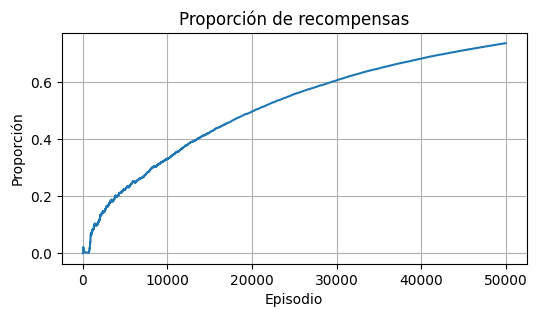

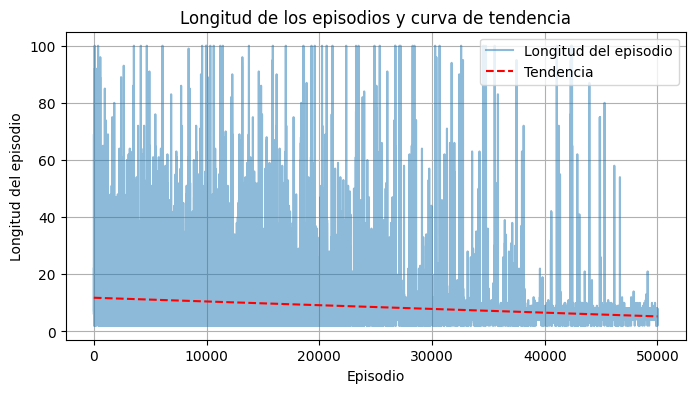

In [ ]:
# Crear la política con epsilon 0.4
epsilon_policy = EpsilonGreedyPolicy(env4.action_space, epsilon=0.4, epsilon_decay=0.99995, epsilon_min=0.01)

# Crear el agente usando MonteCarloOnPolicyAgent y la política
agent_env4 = SARSAAgent(env4, policy=epsilon_policy, alpha=0.3, gamma=0.99, alpha_decay=0.99995, alpha_min=0.01)

# Entrenamos al agente
trained_agent_env4 = train_sarsa(agent_env4, env4, num_episodes=50000, decay=True, decay_alpha=True)

stats = trained_agent_env4.stats()

# Graficamos los resultados
plot_reward_ratio(stats["reward_ratio"])
plot_episode_lengths(stats["episode_lengths"])

In [ ]:
def pi_star_from_Q(env, Q):
    done = False
    pi_star = np.zeros([env.observation_space.n, env.action_space.n])
    state, info = env.reset(seed=100) # start in top-left, = 0
    actions = ""
    while not done:
        action = np.argmax(Q[state, :])
        actions += f"{action}, "
        pi_star[state,action] = action
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
    return pi_star, actions

Q = trained_agent_env4.get_action_values()
pi, actions = pi_star_from_Q(env4, Q)

print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", env4.render())
print()

Política óptima obtenida
 [[0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 0.]] 
 Acciones 2, 2, 1, 1, 1, 2,  
 Para el siguiente grid
   (Right)
SFFF
FHFH
FFFH
HFFG




## FrozenLake - 8x8
Con FrozenLake 8x8 aumentamos el espacio de estados. Mucho mayor que el de 4x4, 16 estados contra 64. Esto significa que el agente debe explorar un espacio más amplio para encontrar la ruta óptima. Por eso poner epsilon a un valor alto y un decaimiento no muy rapido es crucial.

Hemos enfrentado muchos problemas a la hora de encontrar los parámetros óptimos para que llegue a converger a una solución óptima.
* Se ha probado con valores de epsilon más bajos, lo que hacía que no llegase nunca a una solución.
* Valores de alpha más bajos, haciendo que o no llegase a una solución o lo hiciese durante las últimas iteraciones.
* Se ha utilizado un decay exponencial. Ajustar los valores también ha sido un desafio. Muy altos y rapidamente tanto alpha como epsilon eran 0. Muy bajos y no cambiaban dejando un comportamiento casi aleatorio.


 10%|█         | 5089/50000 [00:15<01:26, 520.22it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 1.0
Epsilon actual: 0.0738, Alpha actual: 0.0164


 20%|██        | 10063/50000 [00:23<01:09, 572.29it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 1.0
Epsilon actual: 0.0100, Alpha actual: 0.0100


 30%|███       | 15125/50000 [00:31<01:03, 551.19it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 1.0
Epsilon actual: 0.0100, Alpha actual: 0.0100


 40%|████      | 20108/50000 [00:40<00:53, 555.12it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 1.0
Epsilon actual: 0.0100, Alpha actual: 0.0100


 50%|█████     | 25101/50000 [00:48<00:53, 469.75it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 1.0
Epsilon actual: 0.0100, Alpha actual: 0.0100


 60%|██████    | 30115/50000 [00:56<00:35, 560.78it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 1.0
Epsilon actual: 0.0100, Alpha actual: 0.0100


 70%|███████   | 35090/50000 [01:05<00:26, 566.38it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 1.0
Epsilon actual: 0.0100, Alpha actual: 0.0100


 80%|████████  | 40101/50000 [01:13<00:19, 519.77it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 1.0
Epsilon actual: 0.0100, Alpha actual: 0.0100


 90%|█████████ | 45067/50000 [01:22<00:09, 510.03it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 1.0
Epsilon actual: 0.0100, Alpha actual: 0.0100


100%|██████████| 50000/50000 [01:31<00:00, 548.68it/s]


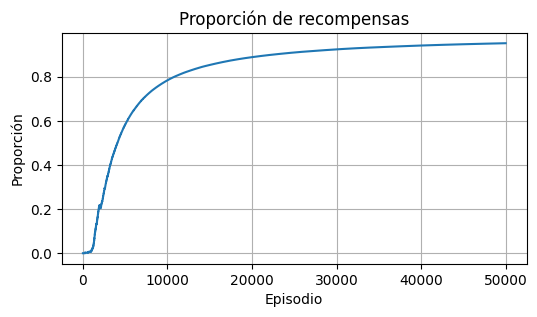

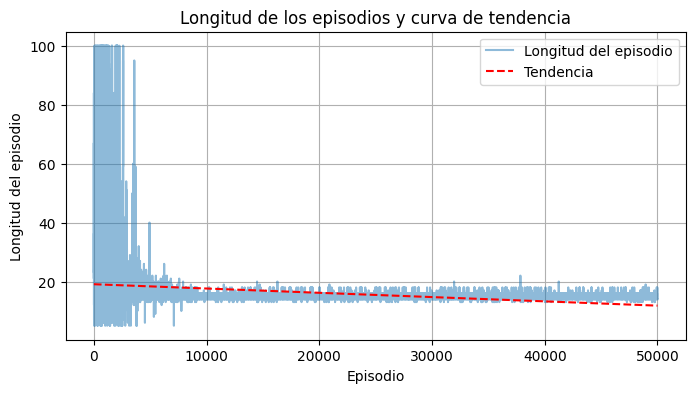

In [ ]:
# Crear la política con epsilon 0.4
epsilon_policy = EpsilonGreedyPolicy(env8.action_space, epsilon=0.9, epsilon_decay=0.9995, epsilon_min=0.01)

# Crear el agente usando MonteCarloOnPolicyAgent y la política
agentEnv8 = SARSAAgent(env8, policy=epsilon_policy, alpha=0.2, gamma=0.99,
                      optimistic_init=True, init_value=1.0,
                      alpha_decay=0.9995, alpha_min=0.01)

# Entrenamos al agente
trained_agent_env8 = train_sarsa(agentEnv8, env8, num_episodes=50000, decay=True, decay_alpha=True, max_step_per_episode=200)

stats = trained_agent_env8.stats()

# Graficamos los resultados
plot_reward_ratio(stats["reward_ratio"])
plot_episode_lengths(stats["episode_lengths"])

In [ ]:
Q = trained_agent_env8.get_action_values()
pi, actions = pi_star_from_Q(env8, Q)

print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", env4.render())
print()

Política óptima obtenida
 [[0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] 
 Acciones 2,

## Taxi

El entorno Taxi tiene un espacio de estados discreto pero complejo, definido por la ubicación del taxi, la ubicación del pasajero y el destino del pasajero.

El agente recibe recompensas por acciones correctas y penalizaciones por acciones incorrectas. Esto introduce un elemnto que requeire que el agente evite acciones negativas.

Aquí hemos optado con lo siguiente:
* Un epsilon inicial de 0.3 para comenzar con una exploración moderada.
* Un decaimiento exponencial muy lento (0.9998) asegurando que el agente continúe explorando durante un período prolongado.
* Un alfa de 0.2 que permite que el agente actualice sus valores Q de manera significativa con cada experiencia, lo que acelera el aprendizaje inicial.


 10%|█         | 5085/50000 [00:19<01:55, 389.47it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 7.0
Epsilon actual: 0.1103, Alpha actual: 0.0736


 20%|██        | 10081/50000 [00:29<01:31, 434.16it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 7.0
Epsilon actual: 0.0406, Alpha actual: 0.0271


 30%|███       | 15076/50000 [00:39<01:19, 440.15it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 7.0
Epsilon actual: 0.0149, Alpha actual: 0.0100


 40%|████      | 20087/50000 [00:49<01:05, 453.33it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 7.0
Epsilon actual: 0.0100, Alpha actual: 0.0100


 50%|█████     | 25064/50000 [00:58<01:13, 339.62it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 7.0
Epsilon actual: 0.0100, Alpha actual: 0.0100


 60%|██████    | 30099/50000 [01:08<00:42, 468.63it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 7.0
Epsilon actual: 0.0100, Alpha actual: 0.0100


 70%|███████   | 35092/50000 [01:18<00:33, 446.08it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 7.0
Epsilon actual: 0.0100, Alpha actual: 0.0100


 80%|████████  | 40064/50000 [01:27<00:21, 461.63it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 7.0
Epsilon actual: 0.0100, Alpha actual: 0.0100


 90%|█████████ | 45047/50000 [01:37<00:13, 354.15it/s]


Porcentaje de éxito: 1.0, Longitud media del episodio: 14.0, Recompensa media: 7.0
Epsilon actual: 0.0100, Alpha actual: 0.0100


100%|██████████| 50000/50000 [01:46<00:00, 470.87it/s]


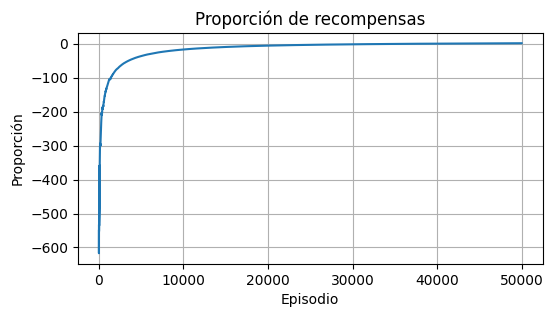

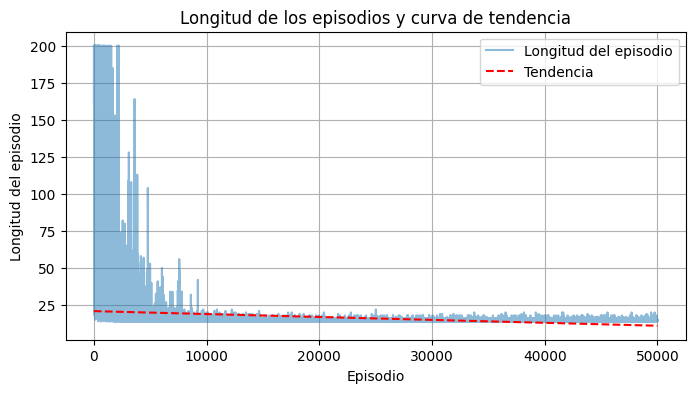

In [ ]:
# Crear la política con epsilon 0.4
epsilon_policy = EpsilonGreedyPolicy(env_taxi.action_space, epsilon=0.3, epsilon_decay=0.9998, epsilon_min=0.01)

# Crear el agente usando MonteCarloOnPolicyAgent y la política
agent_Taxi = SARSAAgent(env_taxi, policy=epsilon_policy, alpha=0.2, gamma=1,
                      alpha_decay=0.9998, alpha_min=0.01)

# Entrenamos al agente
trained_agent_taxi = train_sarsa(agent_Taxi, env_taxi, num_episodes=50000, decay=True, decay_alpha=True)

stats = trained_agent_taxi.stats()

# Graficamos los resultados
plot_reward_ratio(stats["reward_ratio"])
plot_episode_lengths(stats["episode_lengths"])

In [ ]:
Q = trained_agent_taxi.get_action_values()
pi, actions = pi_star_from_Q(env_taxi, Q)

print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", env_taxi.render())
print()

Política óptima obtenida
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]] 
 Acciones 1, 1, 2, 2, 2, 0, 0, 4, 1, 2, 1, 1, 1, 5,  
 Para el siguiente grid
 +---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)


